In [1]:
# write and read from the FSM and compare with LabVIEW vi
import nidaqmx
import numpy as np
from collections import deque
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from skimage import data
from skimage.feature import match_template

from LowLevelModules.NIdaq import *
from LowLevelModules.NIdaqAPD import *

from LowLevelModules.GeneralFunctions import *

from collections import deque

# x,y are FSM axes
conversion = {'x': 13.90, 'y': 9.69} # um/volt ???
# conversion = {'x': 8.58, 'y': 6.22} # um/volt ???

# the ideal coorindate system is the view looking at the sample

def micron_to_volts(pos_in_micron, axis):
    return pos_in_micron / conversion[axis]

def volts_to_micron(pos_in_volts, axis):
    return pos_in_volts * conversion[axis]

def volts_to_micron_list(pos_in_volts, axis):
    con = conversion[axis]
    return pos_in_volts * con

def read_position():
    with nidaqmx.Task() as fsm_task:
        fsm_task.ai_channels.add_ai_voltage_chan('/Dev1/ai1', 'FSM x axis')
        fsm_task.ai_channels.add_ai_voltage_chan('/Dev1/ai0', 'FSM y axis')
        curr_x, curr_y = fsm_task.read()
        curr_x = volts_to_micron(curr_x, 'x')
        curr_y = volts_to_micron(curr_y, 'y')
    return curr_x, curr_y

def read_volt():
    with nidaqmx.Task() as fsm_task:
        fsm_task.ai_channels.add_ai_voltage_chan('/Dev1/ai1', 'FSM x axis')
        fsm_task.ai_channels.add_ai_voltage_chan('/Dev1/ai0', 'FSM y axis')
        curr_x, curr_y = fsm_task.read()
    return curr_x, curr_y

def calc_trajectory_in_V(init,final,numpts,axis):
    offset_sine = (np.sin(np.linspace(-np.pi/2, np.pi/2, numpts))+1)/2 # 0 to 1
    sweep_array = micron_to_volts( offset_sine*(final-init) + init,axis)
    return sweep_array

# position in um
def go_to_position(x, y):
    """
    Go to position (x,y) in um.
    
    Move from current location to final location in a sine wave.    
    """
    curr_x,curr_y = read_position()
    nx = int(np.ceil((abs(x-curr_x)*500+10)/2))
    ny = int(np.ceil((abs(y-curr_y)*500+10)/2))    
    nmax = max(nx,ny)
    
    # 2 arrays need to have the same size
    xVsweep_array = calc_trajectory_in_V(curr_x,x,nmax,'x')
    yVsweep_array = calc_trajectory_in_V(curr_y,y,nmax,'y')
    
#     with nidaqmx.Task() as task:
#         output_volt = task.ao_channels.add_ao_voltage_chan( '/Dev1/ao0', 'FSM y axis', min_val=-9, max_val=9)
#         task.timing.cfg_samp_clk_timing(rate= 50000, 
#                                         active_edge=nidaqmx.constants.Edge.RISING ,
#                                         sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
#                                         samps_per_chan=len(yVsweep_array))
#         task.write(yVsweep_array, auto_start=True, timeout=5)
#         task.wait_until_done(timeout=5)
    
#     with nidaqmx.Task() as task:
#         output_volt = task.ao_channels.add_ao_voltage_chan('/Dev1/ao1', 'FSM x axis', min_val=-9, max_val=9)
#         task.timing.cfg_samp_clk_timing(rate= 50000, 
#                                         active_edge=nidaqmx.constants.Edge.RISING ,
#                                         sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
#                                         samps_per_chan=len(xVsweep_array))
#         task.write(xVsweep_array, auto_start=True, timeout=5)
#         task.wait_until_done(timeout=5)
#     Raphael: I think these two tasks can be combined in one and writing to 2 channels at the same time is possible
#     will be the same as in function read_position() but using AO instead of AI

    with nidaqmx.Task() as task:
        task.ao_channels.add_ao_voltage_chan( '/Dev1/ao0', 'FSM y axis', min_val=-9, max_val=9)
        task.ao_channels.add_ao_voltage_chan('/Dev1/ao1', 'FSM x axis', min_val=-9, max_val=9)
        task.timing.cfg_samp_clk_timing(rate= 50000, 
                                        active_edge=nidaqmx.constants.Edge.RISING ,
                                        sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
                                        samps_per_chan=len(xVsweep_array))
        task.write(np.array([yVsweep_array,xVsweep_array]), auto_start=True, timeout=5)
        task.wait_until_done(timeout=5)

def scan_1D(init,final,mesh_pts,scan_rate,axis,counter_terminal= "/Dev1/PFI0"):
    """
    Scan 1D
    
    Parameters:
    init [um]
    final [um]
    no. points
    rate (Hz)
    axis
    APD terminal
    
    Returns:
    (X [um],APD counts [kCt/s]) list
    """
    counterPort = "/Dev1/ctr1"

    # don't go singificantly above 200 Hz, else the FSM may not be able to catch up
    # such that the AO step by 0.3mV = 20V/2^16 (16 bit output -10 to +10 V)
    mult_fac = 5
    
    ao_scan_rate = scan_rate*mult_fac
    ao_pts = mesh_pts*mult_fac

    # x trajectory 
    axis_scan = np.linspace(init,final, mesh_pts)
    
    # voltage scan is denser than the mesh    
    v_ao_scan = micron_to_volts(np.linspace(init,final, ao_pts),axis)
    
    # clock source
    counter_term_clk = '/Dev1/ctr0'
    trig_src =  '/Dev1/PFI12'       

    # setup counter
    countAPD = CI(counter_terminal, counterPort)
    countAPD.config_read_samples(trig_src,mesh_pts+1,scan_rate)        

    # set up FSM AO AI
    FSMXtask=AO('/Dev1/ao1')
    FSMXtask.config_write(v_ao_scan,ao_scan_rate,trig_src)

    FSMreadXtask = AI('/Dev1/ai1')
    FSMreadXtask.config_read(ao_pts,ao_scan_rate,trig_src)

    # PFI12 start
    # CREATE EXT CLOCK TO GATE THE READING OF PULSES COMING FROM THE APD
    ext_clock_task = CO(counter_term_clk, scan_rate)

    # wait until done and read data
    FSMXtask.wait_until_done()
    FSMXtask.close()

    aiV=FSMreadXtask.read(number_of_samples_per_channel=ao_pts)
    thisX = volts_to_micron(np.asarray(aiV),axis)
    downSampleX = thisX[::mult_fac]
    FSMreadXtask.close()

    rawAPD=countAPD.read(number_of_samples_per_channel=mesh_pts+1)
    correctAPD = np.diff(rawAPD)*scan_rate/1000 # kHz

    countAPD.close()
    ext_clock_task.close()
    return downSampleX,correctAPD     

def scan_2D(curr_x,curr_y,x_size=20,y_size=20,mesh_x=20,mesh_y=20,scan_rate=100):
    """  
    Line by line live plot
    
    Parameters: 
    Returns:
    xx
    yy
    FSM2D (array): Scan image in kHz
    Data format
    FSM[row,col] corresponds to coordinate (X=xx[col],Y=yy[row])    
    """        
    # rectangular scan

    # scan left to right, top to bottom
    startX = curr_x - x_size/2
    endX = curr_x + x_size/2

    startY = curr_y + y_size/2
    endY = curr_y - y_size/2
    
    x_scan = np.linspace(startX,endX, mesh_x)
    y_scan = np.linspace(startY,endY, mesh_y)

    FSM2D = np.zeros((mesh_x,mesh_y))
    
    # similar to LabView control
    # software loop in y
    # hardware loop in X

#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1) 
    lp = LivePlot(1, 1, 5, 3, 'o', 'Coordinate (um)', 'APD counts (kHz)')
    lp2d = LivePlot2DV2( x_scan, y_scan, FSM2D, x_ext=6, y_ext=6)
    
    # Plot 1D scan and 2D plot in real time
    
    for idx,y0 in enumerate(y_scan):
        try:
            go_to_position(startX,y0)

            # setup counter
            xx,correctAPD = scan_1D(startX,endX,mesh_x,scan_rate,'x')
#             FSM2D = np.vstack([FSM2D,correctAPD])
            FSM2D[idx,:]=correctAPD
#             print(idx,y0)
            lp.plot_live(xx, correctAPD)
            lp2d.plot_live(FSM2D)
    #         t = deque(maxlen=max_data_before_refresh)
    #         cts = deque(maxlen=max_data_before_refresh)

            # append new data and plot
    #         t.append(i*delta_t)
    #         cts.append(current_cts)
            #if not i%int(frequency/2):
    #         lp.plot_live(x_scan, thisAPD)

    #         ax.set_xlim(0, i)

#             ax.cla()
#             ax.plot(x_scan, correctAPD)
#             display(fig)

#             clear_output(wait = True)
#             plt.pause(0.5)   

#             countAPD.close()

#             ext_clock_task.close()

        except KeyboardInterrupt:
            # press the stop button to trigger this
#             FSMXtask.close()
#             FSMreadXtask.close()
#             countAPD.close()
#             ext_clock_task.close()
            break
    # back to initial location
    go_to_position(curr_x,curr_y)        
    return x_scan,y_scan,FSM2D

# def scan_2D(curr_x,curr_y,x_size=40,y_size=40,mesh_x=40,mesh_y=40,scan_rate=100):
#     """  
#     Line by line live plot
    
#     Parameters: 
#     Returns: 
#     FSM2D (array): Scan image in kHz
#     """        
# #     go_to_position(0,0)
#     # rectangular scan
#     counter_terminal  = "/Dev1/PFI0"
#     counter_number = "/Dev1/ctr1"
# #     curr_x,curr_y = read_position()

#     # don't go singificantly above 200 Hz, else the FSM may not be able to catch up
#     ao_scan_rate = 200 # such that the AO step by 0.3mV = 20V/2^16 (16 bit output -10 to +10 V)

#     # scan left to right, top to bottom
#     startX = curr_x - x_size/2
#     endX = curr_x + x_size/2

#     startY = curr_y + y_size/2
#     endY = curr_y - y_size/2
#     scan_pts = 100

#     # x trajectory 
#     x_scan = np.linspace(startX,endX, mesh_x)
#     # voltage scan is denser than the actual X mesh
#     v_ao_scan = micron_to_volts(np.linspace(startX,endX, scan_pts),'x')

#     y_scan = np.linspace(startY,endY, mesh_y)

#     counter_term_clk = '/Dev1/ctr0'
#     trig_src =  '/Dev1/PFI12'   
#     counterPort = '/Dev1/ctr1'
#     counter_term = '/Dev1/PFI0' 
#     FSM2D = np.empty((0,mesh_x))
    
#     # lp = LivePlot(1, 1, 8, 5, 'o', 'Time (s)', 'APD counts (kHz)')
#     # similar to LabView control
#     # software loop in y
#     # hardware loop in X


#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1) 
#     # Plot 1D scan and 2D plot in real time
#     for y0 in y_scan:    
#         try:
#             go_to_position(startX,y0)
#             print(y0)
#             # setup counter
#             countAPD = CI(counter_term, counterPort)
#             countAPD.config_read_samples(trig_src,mesh_x+1,scan_rate)        

#             # set up FSM AO AI
#             FSMXtask=AO('/Dev1/ao1')
#             FSMXtask.config_write(v_ao_scan,ao_scan_rate,trig_src)

#             FSMreadXtask = AI('/Dev1/ai1')
#             FSMreadXtask.config_read(scan_pts,ao_scan_rate,trig_src)

#             # PFI12 start
#             # CREATE EXT CLOCK TO GATE THE READING OF PULSES COMING FROM THE APD
#             ext_clock_task = CO(counter_term_clk, scan_rate)

#             # wait until done and read data
#             FSMXtask.wait_until_done()
#             FSMXtask.close()

#             thisX=FSMreadXtask.read(number_of_samples_per_channel=scan_pts)
#             FSMreadXtask.close()

#             thisAPD=countAPD.read(number_of_samples_per_channel=mesh_x+1)
#             correctAPD = np.diff(thisAPD)

#             FSM2D = np.vstack([FSM2D,correctAPD])

#     #         t = deque(maxlen=max_data_before_refresh)
#     #         cts = deque(maxlen=max_data_before_refresh)

#             # append new data and plot
#     #         t.append(i*delta_t)
#     #         cts.append(current_cts)
#             #if not i%int(frequency/2):
#     #         lp.plot_live(x_scan, thisAPD)

#     #         ax.set_xlim(0, i)

#             ax.cla()
#             ax.plot(x_scan, correctAPD)
#             display(fig)

#             clear_output(wait = True)
#             plt.pause(0.5)   

#             countAPD.close()

#             ext_clock_task.close()

#         except KeyboardInterrupt:
#             # press the stop button to trigger this
#             FSMXtask.close()
#             FSMreadXtask.close()
#             countAPD.close()
#             ext_clock_task.close()
#             break
#     go_to_position(curr_x,curr_y)        
#     return FSM2D

def track_NV_2D(template, size,scan_rate):
    """ 
    Track NV given a template (with the NV at its geometric center)
    2D scan keeping objective fixed
  
    Parameters: 
    template (array): NV template with an NV at its geometric center
    size (float): length of the image in um
  
    Returns: 
    (x,y) (float,float): final NV location in um   
    """    
    # pattern match

    # Find NV through either LabView or Python
    # Scan image, say 10 x 10 um with the NV at center, 100 x 100 pts
    # store the image
    # use the center 5 x 5 um as a template (50 x 50 pts)
    template_pt=template.shape[0]
    
    start_pt = int(np.floor(template_pt/4))
    end_pt = int(np.ceil(template_pt*3/4))
    
    row_center = start_pt #(1+template_pt)/2
    col_center = start_pt #(1+template_pt)/2    
    
    template_center = template[start_pt:end_pt, start_pt:end_pt]
    
    # use current x ,y
    curr_x,curr_y = read_position()
    xx1,yy1,FSM2D = scan_2D(curr_x,curr_y,x_size=size,y_size=size,mesh_x=template_pt,mesh_y=template_pt,scan_rate=scan_rate)
    # tracking
    # scan 10 x 10 um
    # use the 5 x 5 um image as a template and find maximum
    # compute the difference
    
    result = match_template(FSM2D, template_center)
    ij = np.unravel_index(np.argmax(result), result.shape)
    col,row = ij[::-1]

    
    dy = size/template_pt*(row_center-row)
    dx = size/template_pt*( col-col_center)
    print(dx,dy)
    if curr_x+dx <-50 or curr_x+dx>50 or curr_y+dx <-50 or curr_y+dy>50:
        print("Out of range, (new x, new y) = ", curr_x+dx ,curr_y+dy )
        return (curr_x,curr_y)
    else:    
        # go to new location
        go_to_position(curr_x+dx,curr_y+dy)
        return (curr_x+dx,curr_y+dy)

<IPython.core.display.Javascript object>


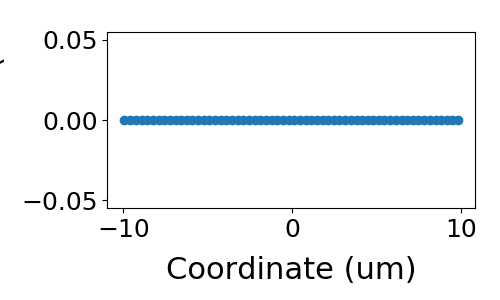

<IPython.core.display.Javascript object>


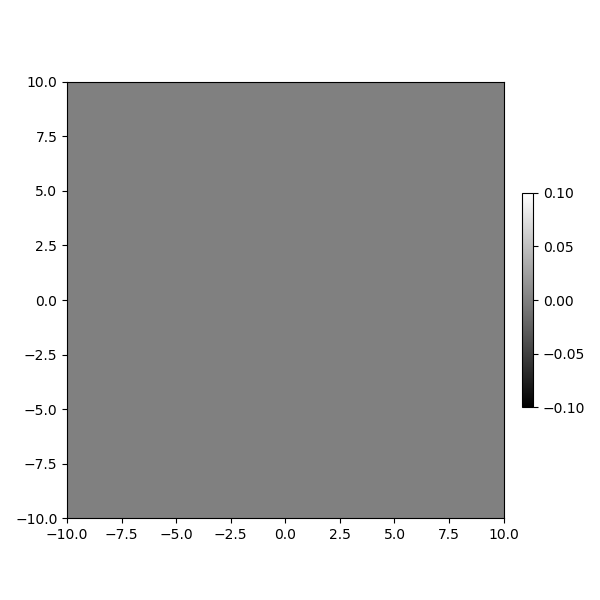

In [2]:
xx,yy,ff=scan_2D(0,0,x_size=20,y_size=20,mesh_x=60,mesh_y=60,scan_rate=200)

In [3]:
tempff

NameError: name 'tempff' is not defined

<IPython.core.display.Javascript object>


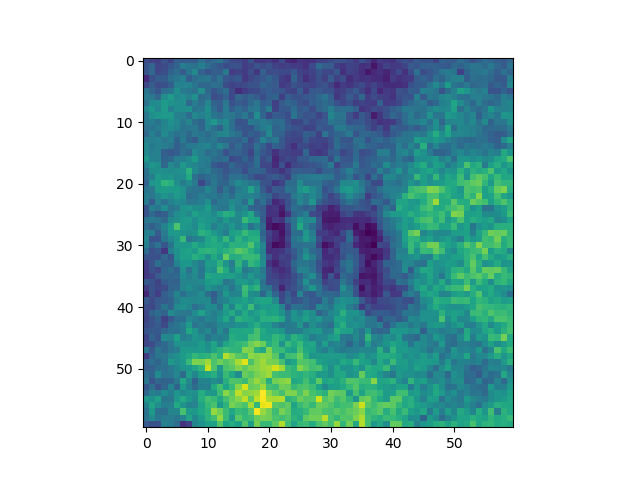

In [8]:
%matplotlib notebook
plt.imshow(ff)
plt.show()

In [4]:
tempff=ff

<IPython.core.display.Javascript object>


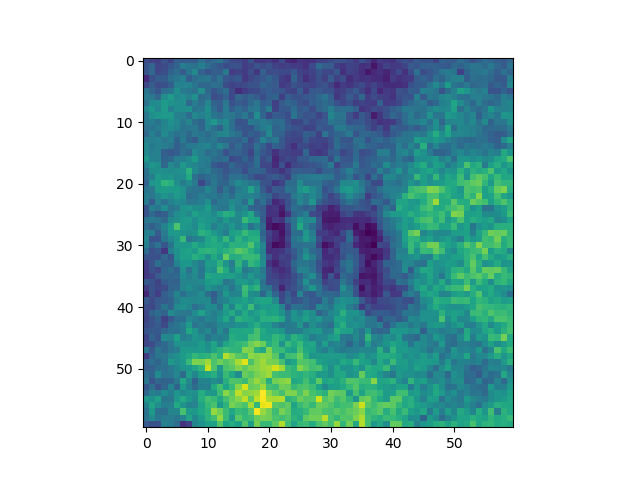

In [10]:
%matplotlib notebook
plt.imshow(tempff)
plt.show()

In [38]:
go_to_position(1.5,3.5)

<IPython.core.display.Javascript object>


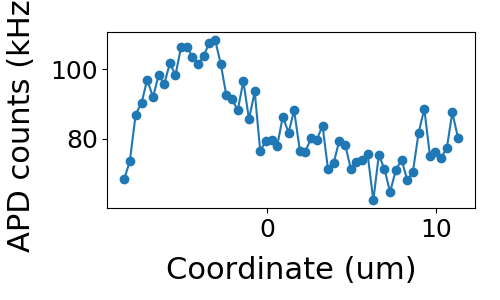

<IPython.core.display.Javascript object>


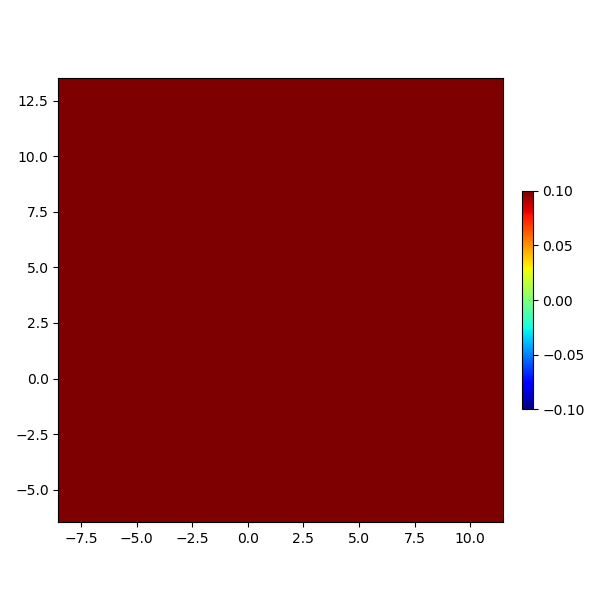

-1.6666666666666665 -3.333333333333333


In [39]:
    template=tempff
    size=20
    scan_rate=200
    
    template_pt=template.shape[0]
    
    start_pt = int(np.floor(template_pt/4))
    end_pt = int(np.ceil(template_pt*3/4))
    
    row_center = start_pt #(1+template_pt)/2
    col_center = start_pt #(1+template_pt)/2    
    
    template_center = template[start_pt:end_pt, start_pt:end_pt]
    
    # use current x ,y
    curr_x,curr_y = read_position()
    xx1,yy1,FSM2D = scan_2D(curr_x,curr_y,x_size=size,y_size=size,mesh_x=template_pt,mesh_y=template_pt,scan_rate=scan_rate)
    # tracking
    # scan 10 x 10 um
    # use the 5 x 5 um image as a template and find maximum
    # compute the difference
    
    result = match_template(FSM2D, template_center)
    ij = np.unravel_index(np.argmax(result), result.shape)
    col,row = ij[::-1]
    
#     col += template_pt/4
#     row += template_pt/4
    
    dy = size/template_pt*(row_center-row)
    dx = size/template_pt*( col-col_center)
    print(dx,dy)
    if curr_x+dx <-50 or curr_x+dx>50 or curr_y+dx <-50 or curr_y+dy>50:
        print("Out of range, (new x, new y) = ", curr_x+dx ,curr_y+dy )
#         return (curr_x,curr_y)
    else:    
        # go to new location
        go_to_position(curr_x+dx,curr_y+dy)
#         return (curr_x+dx,curr_y+dy)

In [40]:
read_position()

(-0.22919044887013154, 0.23547281034214504)

[[ 0.          1.04166667  2.08333333  3.125       4.16666667]
 [        nan         nan         nan         nan         nan]
 [10.41666667 11.45833333 12.5        13.54166667 14.58333333]
 [15.625      16.66666667 17.70833333 18.75       19.79166667]
 [20.83333333 21.875      22.91666667 23.95833333 25.        ]]


<IPython.core.display.Javascript object>


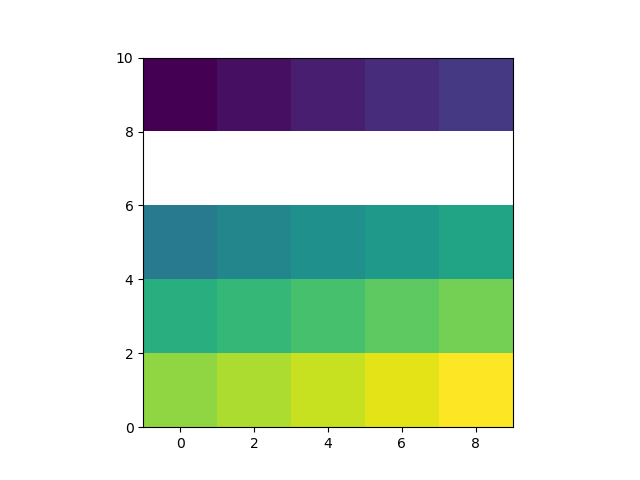

In [6]:
# https://stackoverflow.com/questions/35466455/append-a-1d-array-to-a-2d-array-in-numpy-python
# vstack 2D array
# a = np.empty((0,3), int)
# b = [4,5,6]
# c = [7,8,9]
# H=np.vstack([a,b,c])
aa = np.linspace(0,25,25).reshape((5, 5)) 
aa[1,:]=np.nan
print(aa)
# plt.imshow(aa)
plt.imshow(aa,extent=(-1,9,0,10))
plt.show()

In [43]:
plt.imshow(aa,extent=(-1,9,0,10))
plt.show()


In [7]:
        norm = matplotlib.Normalize(vmin=np.min(z_data),vmax=np.max(z_data))      
        cmap = plt.cm.hot
        plt.cm.ScalarMappable(norm=norm, cmap=cmap)  

AttributeError: module 'matplotlib' has no attribute 'Normalize'

In [39]:
help(nparange

array([[          0, -2147483648, -2147483648, -2147483648, -2147483648],
       [          5,           6,           7,           8,           9],
       [         10,          11,          12,          13,          14],
       [         15,          16,          17,          18,          19],
       [         20,          21,          22,          23,          24]])

In [46]:
# https://stackoverflow.com/questions/2578752/how-can-i-plot-nan-values-as-a-special-color-with-imshow-in-matplotlib
arr = np.arange(100, dtype=float).reshape(10, 10)
arr[~(arr % 7).astype(bool)] = np.nan

In [48]:
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
plt.imshow(arr)
plt.show()

In [42]:
x_scan = np.linspace(0,10,20)
y_scan = np.linspace(10,-1,20)
ff = np.linspace(0,25,400).reshape((20, 20)) 
ff[2,:]=np.nan

<IPython.core.display.Javascript object>


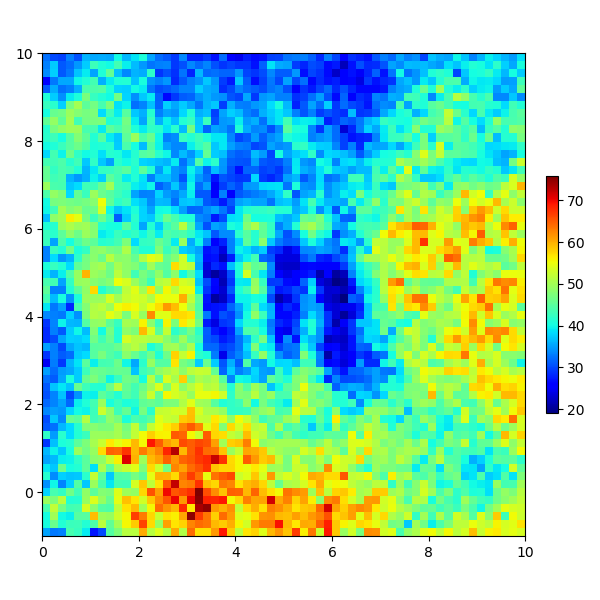

In [43]:
lp2d = LivePlot2DV2( x_scan, y_scan, tempff, x_ext=6, y_ext=6)

In [4]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)
    Display an image, i.e. data on a 2D regular raster.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The data is visualized
          using a colormap.
        - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
        - (M, N, 4): an image with RGBA values (0-1 float or 0-255 int),
          i.e. including transparency.
    
        The first two dimensions (M, N) define the rows and columns of
        the image.
    
        Out-of-range RGB(A) values are clipped.
    
    cmap : str or `~matplotlib.colors.Colormap`, optional
        The 

In [28]:
scan_1D(0,1,10,5,'x')

(array([0.01542915, 0.11830655, 0.22347011, 0.32634751, 0.42236642,
        0.51609916, 0.62354889, 0.73099861, 0.82701752, 0.93218108]),
 array([1.035, 0.91 , 1.04 , 1.045, 0.905, 0.94 , 1.08 , 0.965, 0.93 ,
        1.08 ]))

In [17]:
a

array([0.02685997, 0.08858641, 0.21203929, 0.31948902, 0.42008025,
       0.52067149, 0.62812122, 0.72642628, 0.82930368, 0.93675341])

In [18]:
b


array([0.08, 0.17, 0.07, 0.08, 0.04, 0.11, 0.11, 0.07, 0.15, 0.05])

In [13]:
np.linspace(-1,1,4)

array([-1.        , -0.33333333,  0.33333333,  1.        ])

In [5]:
go_to_position(0,0)
# rectangular scan
x_size = 100 # um
y_size = 100 # um
mesh_x = 40 
mesh_y = 40
counter_terminal  = "/Dev1/PFI0"
counter_number = "/Dev1/ctr1"
curr_x,curr_y = read_position()

# don't go singificantly above 200 Hz, else the FSM may not be able to catch up
scan_rate = 100
ao_scan_rate = 200

# scan left to right, top to bottom
startX = curr_x - x_size/2
endX = curr_x + x_size/2

startY = curr_y + y_size/2
endY = curr_y - y_size/2
scan_pts = 100

# x trajectory 
x_scan = np.linspace(startX,endX, mesh_x)
# voltage scan is denser than the actual X mesh
v_ao_scan = micron_to_volts(np.linspace(startX,endX, scan_pts),'x')

y_scan = np.linspace(startY,endY, mesh_y)

go_to_position(startX,startY) 

In [6]:
counter_term_clk = '/Dev1/ctr0'
trig_src =  '/Dev1/PFI12'   
counterPort = '/Dev1/ctr1'
counter_term = '/Dev1/PFI0' 

In [ ]:
#https://forums.ni.com/t5/Multifunction-DAQ/NIDaqmx-Python-Configure-Analog-Function-Generation/td-p/3743965?profile.language=en

In [103]:
aa  = np.linspace(-4, 5, 100)

with nidaqmx.Task() as task:
        output_volt = task.ao_channels.add_ao_voltage_chan('/Dev1/ao2', 'FSM x axis')
        task.timing.cfg_samp_clk_timing(rate= 1000, sample_mode= nidaqmx.constants.AcquisitionType.FINITE, samps_per_chan= len(aa))
#     FSMAO.timing.samp_timing_type = nidaqmx.constants.SampleTimingType.SAMPLE_CLOCK #
        
        task.write(aa, auto_start=True, timeout=5)
        task.wait_until_done(timeout=5)


AcquisitionType.FINITE
10.0


In [40]:
xx = [2,1,5,3,6,34,1]
np.diff(xx)

array([ -1,   4,  -2,   3,  28, -33])

<IPython.core.display.Javascript object>


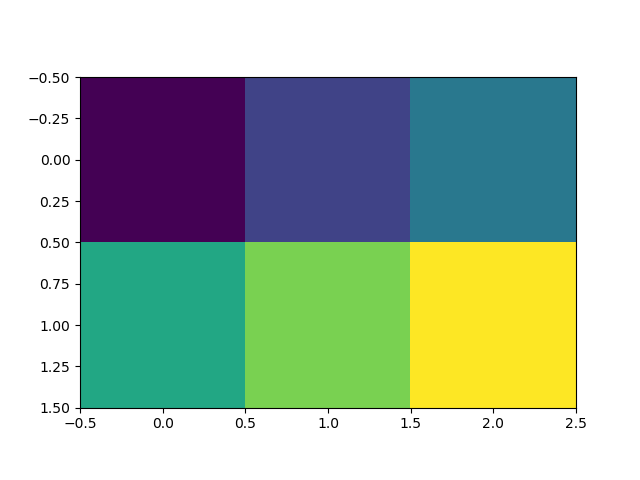

[]


In [36]:
# https://stackoverflow.com/questions/35466455/append-a-1d-array-to-a-2d-array-in-numpy-python
# vstack 2D array
a = np.empty((0,3), int)
b = [4,5,6]
c = [7,8,9]
H=np.vstack([a,b,c])
plt.imshow(H)
plt.show()
FSM2D = np.empty((0,mesh_x))
print(FSM2D)

In [8]:
FSM2D = np.empty((0,mesh_x))


# lp = LivePlot(1, 1, 8, 5, 'o', 'Time (s)', 'APD counts (kHz)')
# similar to LabView control
# software loop in y
# hardware loop in X


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
# Plot 1D scan and 2D plot in real time
for y0 in y_scan:    
    try:
        go_to_position(startX,y0)
        print(y0)
        # setup counter
        countAPD = CI(counter_term, counterPort)
        countAPD.config_read_samples(trig_src,mesh_x+1,scan_rate)        

        # set up FSM AO AI
        FSMXtask=AO('/Dev1/ao1')
        FSMXtask.config_write(v_ao_scan,ao_scan_rate,trig_src)

        FSMreadXtask = AI('/Dev1/ai1')
        FSMreadXtask.config_read(scan_pts,ao_scan_rate,trig_src)

        # PFI12 start
        # CREATE EXT CLOCK TO GATE THE READING OF PULSES COMING FROM THE APD
        ext_clock_task = CO(counter_term_clk, scan_rate)

        # wait until done and read data
        FSMXtask.wait_until_done()
        FSMXtask.close()

        thisX=FSMreadXtask.read(number_of_samples_per_channel=scan_pts)
        FSMreadXtask.close()

        thisAPD=countAPD.read(number_of_samples_per_channel=mesh_x+1)
        correctAPD = np.diff(thisAPD)
    
        FSM2D = np.vstack([FSM2D,correctAPD])
        
#         t = deque(maxlen=max_data_before_refresh)
#         cts = deque(maxlen=max_data_before_refresh)
        
        # append new data and plot
#         t.append(i*delta_t)
#         cts.append(current_cts)
        #if not i%int(frequency/2):
#         lp.plot_live(x_scan, thisAPD)

#         ax.set_xlim(0, i)

        ax.cla()
        ax.plot(x_scan, correctAPD)
        display(fig)

        clear_output(wait = True)
        plt.pause(0.5)   
    
        countAPD.close()

        ext_clock_task.close()
        
    except:
        # press the stop button to trigger this
        FSMXtask.close()
        FSMreadXtask.close()
        countAPD.close()
        ext_clock_task.close()
        break
        
        



-14.183599630951107


In [16]:
# https://pythonprogramming.net/live-graphs-matplotlib-tutorial/
# plot in real time 

FSMXtask.close()
FSMreadXtask.close()
countAPD.close()
ext_clock_task.close()



NameError: name 'FSMXtask' is not defined

In [28]:
countAPD.close()
ext_clock_task.close()

c:\users\fuchsdiamond\appdata\local\programs\python\python37\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "Count pulses" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)
c:\users\fuchsdiamond\appdata\local\programs\python\python37\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "Counter out" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)


In [16]:
go_to_position(1,3 )
read_position()

(1.4122755912759062, 0.26416006204865033)